In [47]:
import networkx as nx
import pandas as pd
import random
import matplotlib.pyplot as plt

In [48]:
# RL Concepts Definitions

class StudentState:
    def __init__(self, completed_courses, gpa, term_number, interests):
        self.completed_courses = completed_courses
        self.gpa = gpa
        self.term_number = term_number
        self.interests = interests

    def __repr__(self):
        return (f"State(Completed: {len(self.completed_courses)} courses, "
                f"GPA: {self.gpa}, Term: {self.term_number}, "
                f"Interests: {self.interests})")

class CourseAction:
    def __init__(self, courses_to_take):
        self.courses_to_take = courses_to_take

    def __repr__(self):
        return f"Action(Courses: {self.courses_to_take})"

def calculate_reward(old_state, new_state, action):
    reward = 0
    
    # 1. GPA Boost 
    gpa_change = new_state.gpa - old_state.gpa
    reward += gpa_change * 10  
    
    # 2. Interest Alignment 
    for course in action.courses_to_take:
        for interest in new_state.interests:
            if interest.lower() in course.lower():
                reward += 1.0 
                
    # 3. Progress Toward Graduation 
    newly_completed_courses = set(new_state.completed_courses.keys()) - set(old_state.completed_courses.keys())
    reward += len(newly_completed_courses) * 2.0 

    return reward

In [49]:
# Part 1: Creates a sample university curriculum graph.

def create_curriculum_graph():
    G = nx.DiGraph()
    courses = {
        "CS101": {"credits": 3, "prerequisites": []},
        "MA101": {"credits": 3, "prerequisites": []},
        "CS201": {"credits": 3, "prerequisites": ["CS101"]},
        "MA201": {"credits": 3, "prerequisites": ["MA101"]},
        "CS301": {"credits": 3, "prerequisites": ["CS201", "MA201"]},
        "DA401": {"credits": 3, "prerequisites": ["CS201", "MA201"]},
        "AI501": {"credits": 3, "prerequisites": ["CS301", "DA401"]},
        "SE501": {"credits": 3, "prerequisites": ["CS301"]},
    }
    for course, data in courses.items():
        G.add_node(course, credits=data["credits"])
        for prereq in data["prerequisites"]:
            G.add_edge(prereq, course)  
    return G, courses

In [50]:
#Part1: Generates simulated student data.

def generate_students(num_students, all_courses):
    students_data = []
    interests_pool = ["AI", "Security", "Data Analysis"]

    for i in range(num_students):
        student_id = f"S{i+1:03d}"
        completed_courses = {}
        gpa = round(random.uniform(2.5, 4.0), 2)
        interests = random.sample(interests_pool, k=random.randint(1, 2))
        term_number = 1 
        num_completed = random.randint(0, len(all_courses) // 2)
        taken_courses = random.sample(list(all_courses.keys()), num_completed)
        for course in taken_courses:
            completed_courses[course] = round(random.uniform(1.0, 4.0), 2) # Grade

        students_data.append({
            "student_id": student_id,
            "completed_courses": completed_courses,
            "gpa": gpa,
            "interests": interests, "term_number": term_number })
        
    return pd.DataFrame(students_data)


In [55]:
# PART 2: Design and implement a high-level personalization algorithm  

def recommend_courses_for_student_rl(student_row, curriculum_graph, all_courses, max_courses_per_term=5):
    old_state = StudentState(
        completed_courses=student_row["completed_courses"],
        gpa=student_row["gpa"],
        term_number=student_row["term_number"],
        interests=student_row["interests"])

    eligible_courses = []
    
    for course, data in all_courses.items():
        if course in old_state.completed_courses:  # Check if course is completed

            continue
        prerequisites_met = True  # Check prerequisites
        for prereq in curriculum_graph.predecessors(course):
            if prereq not in old_state.completed_courses or old_state.completed_courses[prereq] < 1.0: # grade < 1.0 failed
                prerequisites_met = False
                break
        if prerequisites_met:
            eligible_courses.append(course)
            
    prioritized_courses = []  # Prioritize courses based on interests

    for course in eligible_courses:
        interest_score = 0
        for interest in old_state.interests:
            if interest.lower() in course.lower():
                interest_score += 1
        prioritized_courses.append((course, interest_score))

    prioritized_courses.sort(key=lambda x: (-x[1], x[0]))
    
    
    action_courses = [course for course, _ in prioritized_courses[:max_courses_per_term]] # define action
    action = CourseAction(courses_to_take=action_courses)
    
    
    new_completed_courses = old_state.completed_courses.copy() # Simulate taking courses and transitioning to a new state
    simulated_gpa_change = 0
    for course in action.courses_to_take:          # Simulate a grade for the new course

        grade = round(random.uniform(2.0, 4.0), 2) 
        new_completed_courses[course] = grade
        simulated_gpa_change += grade 

    if len(action.courses_to_take) > 0:      # Update GPA 
        new_gpa = (old_state.gpa * len(old_state.completed_courses) + simulated_gpa_change) / \
                  (len(old_state.completed_courses) + len(action.courses_to_take))
    else:
        new_gpa = old_state.gpa
    new_gpa = round(new_gpa, 2)

    new_state = StudentState(
        completed_courses=new_completed_courses,
        gpa=new_gpa,
        term_number=old_state.term_number + 1,
        interests=old_state.interests
    )

    reward = calculate_reward(old_state, new_state, action)  # Calculate the reward

    return action.courses_to_take, reward, new_state


In [56]:
# Visualization

def visualize_graph(graph, filename="curriculum_graph.png"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # For consistent layout
    nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=3000)
    nx.draw_networkx_edges(graph, pos, edge_color="gray", arrowsize=20)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")
    plt.title("Curriculum Graph")
    plt.axis("off")
    plt.savefig(filename)
    print(f"Graph visualization saved to {filename}")

In [60]:
if __name__ == "__main__":
    curriculum_graph, all_courses = create_curriculum_graph()
    print("Curriculum Graph Nodes:", curriculum_graph.nodes(data=True))
    print ("##################################################################################################################")
    print("Curriculum Graph Edges:", curriculum_graph.edges())
    print ("##################################################################################################################")

    students_df = generate_students(100, all_courses)
    print("\nSample Student Data (first 5):\n", students_df.head())
    print ("##################################################################################################################")

    print("\nGenerating course recommendations for students.")
    results = students_df.apply(
       lambda row: recommend_courses_for_student_rl(row, curriculum_graph, all_courses),axis=1)
    
    students_df["recommended_courses"] = [x[0] for x in results]
    students_df["reward"] = [x[1] for x in results]
    students_df["new_state"] = [x[2] for x in results]
    print ("##################################################################################################################")

    print("\nSample Student Data with Recommendations, Rewards, and New States :\n") #first 5
    
    print ("##################################################################################################################")

    print(students_df[["student_id", "interests", "completed_courses", "gpa", "term_number", "recommended_courses", 
                       "reward", "new_state"]].head())
    
    print ("##################################################################################################################")


    for i in range(3):
        student = students_df.iloc[i]
        print(f'\nStudent ID: {student["student_id"]}')
        print(f'  Interests: {student["interests"]}')
        print(f'  Initial Completed Courses: {student["completed_courses"]}')
        print(f'  Initial GPA: {student["gpa"]}')
        print(f'  Initial Term: {student["term_number"]}')
        print(f'  Recommended Courses for next term: {student["recommended_courses"]}')
        print(f'  Calculated Reward: {student["reward"]}')
        print(f'  New State: {student["new_state"]}')

print ("##################################################################################################################")
  

Curriculum Graph Nodes: [('CS101', {'credits': 3}), ('MA101', {'credits': 3}), ('CS201', {'credits': 3}), ('MA201', {'credits': 3}), ('CS301', {'credits': 3}), ('DA401', {'credits': 3}), ('AI501', {'credits': 3}), ('SE501', {'credits': 3})]
##################################################################################################################
Curriculum Graph Edges: [('CS101', 'CS201'), ('MA101', 'MA201'), ('CS201', 'CS301'), ('CS201', 'DA401'), ('MA201', 'CS301'), ('MA201', 'DA401'), ('CS301', 'AI501'), ('CS301', 'SE501'), ('DA401', 'AI501')]
##################################################################################################################

Sample Student Data (first 5):
   student_id               completed_courses   gpa            interests  \
0       S001                 {'CS201': 2.86}  2.62  [AI, Data Analysis]   
1       S002  {'MA201': 2.61, 'AI501': 1.33}  3.38           [Security]   
2       S003                              {}  3.99      [Data Anal

Graph visualization saved to curriculum_graph.png


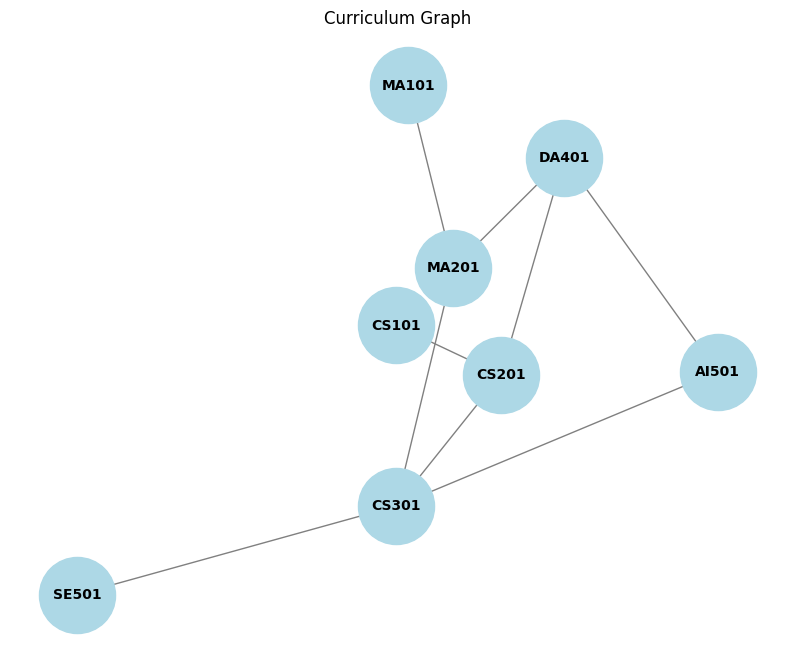

In [54]:
    visualize_graph(curriculum_graph)
